In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
test = pd.read_csv("./test.csv/test.csv")

In [2]:
clientdata = pd.read_csv("./cliente_tabla.csv/cliente_tabla.csv")
productdata = pd.read_csv("./producto_tabla.csv/producto_tabla.csv")
townstate = pd.read_csv("./town_state.csv/town_state.csv")

In [7]:
import findspark
findspark.init()

In [8]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [12]:
from pyspark.sql.types import StructField,StringType,IntegerType,StructType, DoubleType, ShortType, ByteType
data_schema = [StructField("WeekNumber", ByteType(), True),StructField("DepotID", ShortType(), True),
              StructField("SalesChannelID", ByteType(), True),StructField("RouteID", ShortType(), True),
              StructField("ClientID", IntegerType(), True),StructField("ProductID", ShortType(), True),
              StructField("SalesUnits", ShortType(), True),StructField("Sales", DoubleType(), True),
              StructField("ReturnUnits", IntegerType(), True),StructField("Returns", DoubleType(), True),
              StructField("Demand", IntegerType(), True)]
final_struc = StructType(fields=data_schema)
df = spark.read.csv("./train.csv/train.csv", schema=final_struc)

root
 |-- WeekNumber: byte (nullable = true)
 |-- DepotID: short (nullable = true)
 |-- SalesChannelID: byte (nullable = true)
 |-- RouteID: short (nullable = true)
 |-- ClientID: integer (nullable = true)
 |-- ProductID: short (nullable = true)
 |-- SalesUnits: short (nullable = true)
 |-- Sales: double (nullable = true)
 |-- ReturnUnits: integer (nullable = true)
 |-- Returns: double (nullable = true)
 |-- Demand: integer (nullable = true)



In [13]:
import dask
import dask.dataframe as dd

In [3]:
# Loading in the train data
dtypes = {'Semana':'uint8',
          'Agencia_ID': 'uint16',
          'Canal_ID': 'uint8',
          'Ruta_SAK': 'uint16',
          'Cliente_ID': 'uint32',
          'Producto_ID': 'uint16',
          'Venta_uni_hoy': 'uint16',
          'Venta_hoy': 'float64',
          'Dev_uni_proxima': 'uint32',
          'Dev_proxima': 'float64',
          'Demanda_uni_equil': 'uint16'}


50

In [4]:
clientdata['Cliente_ID'].nunique()

930500

In [5]:
productdata['Producto_ID'].nunique()

2592

In [4]:
#We will try to use 20% of client data in eah chunk and then merge those chunks together to create the final training set.
tablesList = []
chunkIter = pd.read_csv("./train.csv/train.csv", dtype=dtypes,  chunksize= 1000000, usecols=['Semana',
          'Agencia_ID',
          'Canal_ID',
          'Ruta_SAK',
          'Cliente_ID',
          'Producto_ID',
          'Venta_uni_hoy',
          'Dev_uni_proxima',
          'Demanda_uni_equil'])
for index, chunk in enumerate(chunkIter):
    table = chunk.sample(frac =0.2) 
    tablesList.append(table)

In [5]:
train = pd.concat(tablesList)

In [24]:
#Feature Engineering which needs to be applied to the whole data set. 

In [6]:
ClientCounts = clientdata['NombreCliente'].value_counts()
cleanClientData = pd.DataFrame(data=ClientCounts.index.values, columns=['Name'])
cleanClientData.reset_index(inplace=True)

In [7]:
import re
#Split the string at the first digit character:
productdata['shortname'] = productdata['NombreProducto'].apply(lambda x:  re.split("\s\d", x, 1)[0])
productValues = productdata['shortname'].value_counts()
productID = pd.DataFrame(data=productValues.index.values, columns=['Name'])
productID.reset_index(inplace=True)
productdata = productdata.merge(productID,left_on=['shortname'],right_on=['Name'])
productdata

,Producto_ID,NombreProducto,shortname,index,Name
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,606,NO IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,688,Capuccino Moka
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,172,Bimbollos Ext sAjonjoli
3,34850,Bimbollos Ext sAjonjoli 6p 480g TNB BIM 34850,Bimbollos Ext sAjonjoli,172,Bimbollos Ext sAjonjoli
4,43128,Bimbollos Ext sAjonjoli 6p 480g MTA BIM 43128,Bimbollos Ext sAjonjoli,172,Bimbollos Ext sAjonjoli
...,...,...,...,...,...
2587,49773,Bombonete San Valentin 3p 55g MLA 49773,Bombonete San Valentin,748,Bombonete San Valentin
2588,49835,Bimkingo Clasico Prom 135g LON 49835,Bimkingo Clasico Prom,1001,Bimkingo Clasico Prom
2589,49944,Pan Blanco Bimbo Rendidor 567g TNB BIM 49944,Pan Blanco Bimbo Rendidor,242,Pan Blanco Bimbo Rendidor
2590,49972,Pan Blanco Bimbo Rendidor 567g MTA BIM 49972,Pan Blanco Bimbo Rendidor,242,Pan Blanco Bimbo Rendidor


In [8]:
train['CatProductID'] = train.reset_index().merge(productdata,left_on=['Producto_ID'],
                                                  right_on=['Producto_ID']).set_index('index_x')['index_y']

In [9]:
#ClientID should be unique
clientdata = clientdata.merge(cleanClientData,left_on=['NombreCliente'],right_on=['Name'])
uniclientData = clientdata.groupby(['Cliente_ID']).mean().reset_index()

In [10]:
train['CleanClientID'] = train.reset_index().merge(uniclientData,left_on=['Cliente_ID'],
                                                  right_on=['Cliente_ID']).set_index('index_x')['index_y']

In [11]:
townValues = townstate['Town'].value_counts()
townID = pd.DataFrame(data=townValues.index.values, columns=['Name'])

In [12]:
townstate = townstate.merge(townID,left_on=['Town'],right_on=['Name'])
townstate.reset_index(inplace=True)

In [13]:
train['TownID'] = train.reset_index().merge(townstate,left_on=['Agencia_ID'],
                                            right_on=['Agencia_ID']).set_index('index_x')['index_y']

In [36]:
#Dividing data into featureInput, train and cv sets
featureInput = train[train['Semana'] < 6].copy()
trainSet = train[(train['Semana'] == 6) | (train['Semana'] == 7)].copy()
crossVal = train[train['Semana'] == 8].copy()


In [ ]:
trainSet['AggProductSales'] = trainSet.reset_index().merge(featureInput.groupby('Producto_ID').sum()['Demanda_uni_equil'], on='Producto_ID').set_index('index')['Demanda_uni_equil_y']
trainSet['AvgClientProdDemand'] = trainSet.reset_index().merge(train.groupby(['ClientID','ProductID']).mean()['Demanda_uni_equil'], on=['ClientID','ProductID']).set_index('index')['Demand_y']
trainSet['AvgWeeklyClientDemand'] = trainSet.reset_index().merge((train.groupby(['ClientID']).sum()['Demanda_uni_equil'])/3, on=['ClientID']).set_index('index')['Demand_y']
trainSet['AggTownProductDemand'] = trainSet.reset_index().merge(train.groupby(['TownID','ProductID']).sum()['Demanda_uni_equil'], on=['TownID','ProductID']).set_index('index')['Demand_y']
trainSet['StdClientProdDemand'] = trainSet.reset_index().merge(train.groupby(['ClientID','ProductID']).std()['Demanda_uni_equil'], on=['ClientID','ProductID']).set_index('index')['Demand_y']
#agg demand of product on a route
#Number of routes in a depot
#Product Count for each client in each town

In [88]:
trainSet

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Dev_uni_proxima,Demanda_uni_equil,CatProductID,CleanClientID,TownID,AggProductSales,AvgClientProdDemand,AvgWeeklyClientDemand,AggTownProductDemand,StdClientProdDemand,AggRouteProdDemand,NoOfRoutesinDepot,AverageClientProdCount
32928484,6,1113,1,2803,4504456,30575,1,0,1,18,0.0,72,609859.0,NaN,3.333333,3504.0,NaN,4247.0,356.0,1.333333
32796211,6,1110,7,3321,1549700,35651,8,0,8,53,145071.0,72,815192.0,NaN,11.333333,8984.0,NaN,239.0,184.0,2.666667
32987108,6,1116,1,1619,118224,323,2,0,2,94,2550.0,1,27104.0,NaN,93.000000,1673.0,NaN,642.0,543.0,9.666667
32816128,6,1111,1,1215,4243092,1272,1,0,1,660,0.0,48,13250.0,3.0,23.333333,646.0,NaN,22.0,489.0,7.000000
32856302,6,1111,1,4413,39168,32846,3,0,3,76,600.0,48,7182.0,NaN,43.000000,137.0,NaN,76.0,250.0,7.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53239660,7,23879,1,1022,8355695,1146,1,0,1,5,839.0,256,544784.0,NaN,9.666667,636.0,NaN,5598.0,113.0,3.000000
53219380,7,23719,1,1166,508800,35651,1,0,1,53,173.0,240,815192.0,NaN,2.666667,884.0,NaN,2818.0,444.0,1.666667
53118711,7,22414,1,1209,263573,1220,4,0,4,176,2523.0,235,260296.0,2.0,9.333333,1409.0,NaN,1348.0,310.0,2.333333
53162746,7,22560,1,1259,678147,31423,8,0,8,227,4976.0,238,130442.0,12.0,139.666667,1348.0,NaN,262.0,504.0,6.666667


In [91]:
#Demand for Prior 3 weeks for Weeks -> 3,4,5
for week in range(6,8):
    for prevweek in range(1,4):
        indices = trainSet[trainSet['Semana'] == week].index.values
        trainSet.loc[indices,('PriorWeekDem'+ str(prevweek))] = trainSet.reset_index().merge(featureInput[featureInput['Semana'] == (week-prevweek)].copy().groupby(['Cliente_ID','Producto_ID']).mean()['Demanda_uni_equil'], on=['Cliente_ID','Producto_ID']).set_index('index')['Demanda_uni_equil_y']

   

In [58]:
 #Categorical demand for previous 2 weeks.
for week in range(6,8):
    for prevweek in range(1,3):
        indices = trainSet[trainSet['Semana'] == week].index.values
        trainSet.loc[indices,('PriorWeekCatDem'+ str(prevweek))] = trainSet.reset_index().merge(featureInput[featureInput['Semana'] == (week-prevweek)].copy().groupby(['CleanClientID','CatProductID']).mean()['Demanda_uni_equil'], on=['CleanClientID','CatProductID']).set_index('Unnamed: 0')['Demanda_uni_equil_y']


In [93]:
#Applying similar changes on the test set as well

In [18]:
def featureExtraction(trainSet,featureInput, startweek, endweek, numWeeks):
    trainSet['AggProductSales'] = trainSet.reset_index().merge(featureInput.groupby('Producto_ID').sum()['Demanda_uni_equil'], on='Producto_ID').set_index('index')['Demanda_uni_equil_y']
    trainSet['AvgClientProdDemand'] = trainSet.reset_index().merge(featureInput.groupby(['Cliente_ID','Producto_ID']).mean()['Demanda_uni_equil'], on=['Cliente_ID','Producto_ID']).set_index('index')['Demanda_uni_equil_y']
    trainSet['AvgWeeklyClientDemand'] = trainSet.reset_index().merge((featureInput.groupby(['Cliente_ID']).sum()['Demanda_uni_equil'])/numWeeks, on=['Cliente_ID']).set_index('index')['Demanda_uni_equil_y']
    trainSet['AggTownProductDemand'] = trainSet.reset_index().merge(featureInput.groupby(['TownID','Producto_ID']).sum()['Demanda_uni_equil'], on=['TownID','Producto_ID']).set_index('index')['Demanda_uni_equil_y']
    trainSet['StdClientProdDemand'] = trainSet.reset_index().merge(featureInput.groupby(['Cliente_ID','Producto_ID']).std()['Demanda_uni_equil'], on=['Cliente_ID','Producto_ID']).set_index('index')['Demanda_uni_equil_y']
    trainSet['AggRouteProdDemand'] = trainSet.reset_index().merge(featureInput.groupby(['Ruta_SAK','Producto_ID']).sum()['Demanda_uni_equil']/numWeeks, on=['Ruta_SAK','Producto_ID']).set_index('index')['Demanda_uni_equil_y']
    trainSet['NoOfRoutesinDepot'] = trainSet.reset_index().merge(featureInput.groupby(['Agencia_ID','Ruta_SAK']).count()['Demanda_uni_equil']/numWeeks, on=['Agencia_ID','Ruta_SAK']).set_index('index')['Demanda_uni_equil_y']
    trainSet['AverageClientProdCount'] = trainSet.reset_index().merge(featureInput.groupby(['Cliente_ID']).count()['Demanda_uni_equil']/numWeeks, on=['Cliente_ID']).set_index('index')['Demanda_uni_equil_y']

    for week in range(startweek,endweek):
        for prevweek in range(1,4):
            indices = trainSet[trainSet['Semana'] == week].index.values
            trainSet.loc[indices,('PriorWeekDem'+ str(prevweek))] = trainSet.reset_index().merge(featureInput[featureInput['Semana'] == (week-prevweek)].copy().groupby(['Cliente_ID','Producto_ID']).mean()['Demanda_uni_equil'], on=['Cliente_ID','Producto_ID']).set_index('index')['Demanda_uni_equil_y']


In [46]:
#Running the feature extraction for testset
featureInput = train[train['Semana'] < 8].copy()
featureExtraction(crossVal, featureInput, 8, 9, 5)

In [24]:
trainSet.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Dev_uni_proxima,Demanda_uni_equil,CatProductID,...,AggTownProductDemand,StdClientProdDemand,AggRouteProdDemand,NoOfRoutesinDepot,AverageClientProdCount,PriorWeekDem1,PriorWeekDem2,PriorWeekDem3,PriorWeekCatDem1,PriorWeekCatDem2
53692946,8,1118,1,1203,4406352,1109,4,0,4,108,...,10771.0,NaN,753.2,160.6,5.0,NaN,NaN,NaN,2.599327,2.565740
53983224,8,1122,1,1498,603536,1232,11,0,11,238,...,9834.0,NaN,30.0,153.8,6.0,NaN,NaN,NaN,NaN,NaN
53875816,8,1121,1,1415,2086994,972,2,0,2,37,...,3220.0,0.0,242.0,190.4,5.6,4.0,NaN,NaN,2.666667,2.000000
53428789,8,1111,1,2123,4557817,31507,3,0,3,168,...,2792.0,NaN,579.2,42.2,0.2,NaN,NaN,NaN,5.137011,5.094823
53655590,8,1117,1,1479,1035980,1230,2,2,0,193,...,2469.0,NaN,55.6,115.2,5.6,NaN,NaN,NaN,1.833333,1.714286


In [55]:
trainSet = pd.read_csv("trainSet.csv")
trainSet.set_index("Unnamed: 0", inplace = True)

In [47]:
for week in range(8,9):
        for prevweek in range(1,3):
            indices = crossVal[crossVal['Semana'] == week].index.values
            crossVal.loc[indices,('PriorWeekCatDem'+ str(prevweek))] = crossVal.reset_index().merge(featureInput[featureInput['Semana'] == (week-prevweek)].copy().groupby(['CleanClientID','CatProductID']).mean()['Demanda_uni_equil'], on=['CleanClientID','CatProductID']).set_index('index')['Demanda_uni_equil_y']


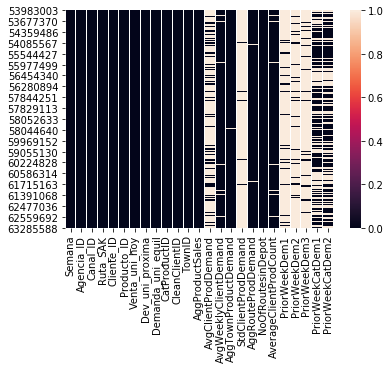

In [58]:
sns.heatmap(crossVal.isna())

In [31]:
crossVal.dropna(thresh=19, inplace=True)

In [62]:
trainSet.dropna(thresh=19, inplace=True)

TypeError: object of type 'NoneType' has no len()

In [54]:
testSet.dropna(thresh=19, inplace=True)

In [63]:
trainSet.drop(['Venta_uni_hoy','Dev_uni_proxima'], axis=1, inplace=True)
crossVal.drop(['Venta_uni_hoy','Dev_uni_proxima'], axis=1, inplace=True)
testSet.drop(['Venta_uni_hoy','Dev_uni_proxima'], axis=1, inplace=True)

In [26]:
testSet = train[train['Semana'] == 9].copy()
featureInputforTest = train[train['Semana'] < 9].copy()
featureExtraction(testSet, featureInputforTest, 9, 10, 6)

In [28]:
for week in range(9,10):
        for prevweek in range(1,3):
            indices = testSet[testSet['Semana'] == week].index.values
            testSet.loc[indices,('PriorWeekCatDem'+ str(prevweek))] = testSet.reset_index().merge(featureInput[featureInput['Semana'] == (week-prevweek)].copy().groupby(['CleanClientID','CatProductID']).mean()['Demanda_uni_equil'], on=['CleanClientID','CatProductID']).set_index('index')['Demanda_uni_equil_y']


In [72]:
trainSet.max()

Semana                    7.000000e+00
Agencia_ID                2.575900e+04
Canal_ID                  1.100000e+01
Ruta_SAK                  9.962000e+03
Cliente_ID                2.015152e+09
Producto_ID               4.999400e+04
Demanda_uni_equil         4.165000e+03
CatProductID              1.014000e+03
CleanClientID             3.111520e+05
TownID                    2.590000e+02
AggProductSales           2.041605e+06
AvgClientProdDemand       4.011000e+03
AvgWeeklyClientDemand     5.275037e+05
AggTownProductDemand      1.017600e+05
StdClientProdDemand       1.780495e+03
AggRouteProdDemand        3.234100e+04
NoOfRoutesinDepot         8.490000e+02
AverageClientProdCount    3.582333e+03
PriorWeekDem1             4.011000e+03
PriorWeekDem2             3.920000e+03
PriorWeekDem3             2.956000e+03
PriorWeekCatDem1          2.118000e+03
PriorWeekCatDem2          1.886500e+03
dtype: float64

In [75]:
dtypes = {'Semana':'uint8',
          'Agencia_ID': 'uint16',
          'Canal_ID': 'uint8',
          'Ruta_SAK': 'uint16',
          'Cliente_ID': 'uint32',
          'Producto_ID': 'uint16',
          'Demanda_uni_equil': 'uint16',
          'CatProductID' : 'uint16',
          'CleanClientID' : 'float16',
          'TownID' : 'uint16',
          'AggProductSales' : 'float32',
          'AvgClientProdDemand' : 'float16',
          'AggTownProductDemand' : 'float32',
          'AvgWeeklyClientDemand' : 'float32',
          'StdClientProdDemand' : 'float16',
          'AggRouteProdDemand' : 'float16',
          'NoOfRoutesinDepot' : 'float16',
          'AverageClientProdCount' : 'float16',
          'PriorWeekDem1' : 'float16',
          'PriorWeekDem2' : 'float16',
          'PriorWeekDem3' : 'float16',
          'PriorWeekCatDem1' : 'float16',
          'PriorWeekCatDem2' : 'float16'
         }

In [78]:
trainSet = trainSet.astype(dtypes)
crossVal = crossVal.astype(dtypes)
testSet = testSet.astype(dtypes)

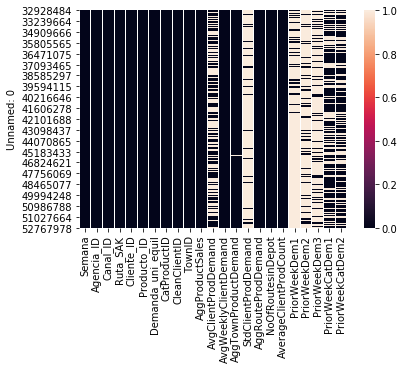

In [79]:
sns.heatmap(trainSet.isna())

In [87]:
trainSet.to_csv("TrainingSet.csv")


In [86]:
crossVal.to_csv("CrossVal.csv")
testSet.to_csv("TestSet.csv")
train.to_csv("FullVerTrain.csv")

In [88]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171712 entries, 32928484 to 53033063
Data columns (total 23 columns):
Semana                    uint8
Agencia_ID                uint16
Canal_ID                  uint8
Ruta_SAK                  uint16
Cliente_ID                uint32
Producto_ID               uint16
Demanda_uni_equil         uint16
CatProductID              uint16
CleanClientID             float16
TownID                    uint16
AggProductSales           float32
AvgClientProdDemand       float16
AvgWeeklyClientDemand     float32
AggTownProductDemand      float32
StdClientProdDemand       float16
AggRouteProdDemand        float16
NoOfRoutesinDepot         float16
AverageClientProdCount    float16
PriorWeekDem1             float16
PriorWeekDem2             float16
PriorWeekDem3             float16
PriorWeekCatDem1          float16
PriorWeekCatDem2          float16
dtypes: float16(11), float32(3), uint16(6), uint32(1), uint8(2)
memory usage: 124.3 MB
